In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
class CharTokenizer(BaseTokenizer):
    def __init__(self, lang:str):             super().__init__(lang=lang)
    def tokenizer(self, t:str) -> List[str]:  return(list(t))
    
char_tokenize_processor = TokenizeProcessor(tokenizer=Tokenizer(tok_func=CharTokenizer), include_bos=False)

# Peptide Language Model

In [4]:
path = '/home/danxu/nfs_danxu/python_nbs/DL_Neoantigen'
db_path = path + '/data/DL_NeoAntigen/db'
m_path = path + '/models'

bs = 128

In [30]:
data_lm = (TextList.from_csv(db_path, 'uniprot_sprot.human.csv', cols='pepseq',
                               processor=[char_tokenize_processor, NumericalizeProcessor()])
                .split_by_rand_pct(0.1)
                .label_for_lm()
                .databunch(bs=bs))

In [31]:
data_lm.save('uniprot_lm.human.pkl')

In [5]:
data_lm = load_data(db_path, 'uniprot_lm.human.pkl', bs=bs)

In [6]:
data_lm.show_batch()

idx,text
0,t e r n e k k q q m g k e y r e k i e a e l q d i c n d v l e l l d k y l i p n a t q p e s k v f y l k m k g d y f r y l s e v a s g d n k
1,a r l y y y r d r d w r w v l l r l h k a g a r v k i m d y e d f a y c w e n f v c n e g q p f m p w y k f d d n y a s l h r t l k e i l r
2,g m i m a a r g s g p r a l r x x r e p 4 l v q l v a g r c g l a g a a g g a q r g l s e p s s i a k h e d s l l k d l f q
3,k w q l t k g l r d v a k s t s s e s g g v s s p g k e e r e q s t r k e n i q t g p r t r s p t i l e t s p r l i r k a l e f m d l s q y
4,a l p k m k a s k s g v s l p q r d v d p s l s s a t a g g s f q d t e k a s s d g g r g g l g a t a s a t g s e g v n l h r p q v h i p s


In [7]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, pretrained=False)

In [17]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


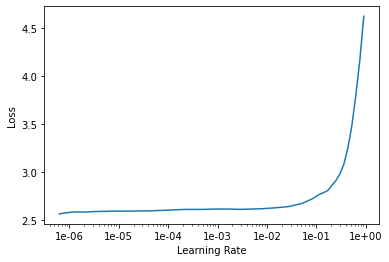

In [18]:
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.849938,2.856114,0.115403,02:26


In [11]:
learn.save('/home/danxu/nfs_danxu/python_nbs/DL_Neoantigen/models/uniprot_lm_human_head')

In [15]:
learn.load('/home/danxu/nfs_danxu/python_nbs/DL_Neoantigen/models/uniprot_lm_human_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (18169 items)
x: LMTextList
m t m d k s e l v q k a k l a e q a e r y d d m a a a m k a v t e q g h e l s n e e r n l l s v a y k n v v g a r r s s w r v i s s i e q k t e r n e k k q q m g k e y r e k i e a e l q d i c n d v l e l l d k y l i p n a t q p e s k v f y l k m k g d y f r y l s e v a s g d n k q t t v s n s q q a y q e a f e i s k k e m q p t h p i r l g l a l n f s v f y y e i l n s p e k a c s l a k t a f d e a i a e l d t l n e e s y k d s t l i m q l l r d n l t l w t s e n q g d e g d a g e g e n,m d d r e d l v y q a k l a e q a e r y d e m v e s m k k v a g m d v e l t v e e r n l l s v a y k n v i g a r r a s w r i i s s i e q k e e n k g g e d k l k m i r e y r q m v e t e l k l i c c d i l d v l d k h l i p a a n t g e s k v f y y k m k g d y h r y l a e f a t g n d r k e a a e n s l v a y k a a s d i a m t e l p p t h p i r l g l a l n f s v f y y e i l n s p d r a c r l a k a a f d d a i a e l d t l s e e 

In [12]:
learn.unfreeze()

In [23]:
learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.378797,2.629303,0.202997,02:27
1,2.431806,2.621450,0.201457,02:28
2,2.448062,2.619581,0.201333,02:28
3,2.418123,2.614988,0.202883,02:28
4,2.374504,2.616343,0.204361,02:28
5,2.374597,2.623486,0.205599,02:28
6,2.333418,2.627048,0.206232,02:29
7,2.285729,2.631917,0.206052,02:29


In [22]:
learn.save(f'{m_path}/uniprot_lm_human_fine_tuned')

In [44]:
learn.load(f'{m_path}/uniprot_lm_human_fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (18169 items)
x: LMTextList
m t m d k s e l v q k a k l a e q a e r y d d m a a a m k a v t e q g h e l s n e e r n l l s v a y k n v v g a r r s s w r v i s s i e q k t e r n e k k q q m g k e y r e k i e a e l q d i c n d v l e l l d k y l i p n a t q p e s k v f y l k m k g d y f r y l s e v a s g d n k q t t v s n s q q a y q e a f e i s k k e m q p t h p i r l g l a l n f s v f y y e i l n s p e k a c s l a k t a f d e a i a e l d t l n e e s y k d s t l i m q l l r d n l t l w t s e n q g d e g d a g e g e n,m d d r e d l v y q a k l a e q a e r y d e m v e s m k k v a g m d v e l t v e e r n l l s v a y k n v i g a r r a s w r i i s s i e q k e e n k g g e d k l k m i r e y r q m v e t e l k l i c c d i l d v l d k h l i p a a n t g e s k v f y y k m k g d y h r y l a e f a t g n d r k e a a e n s l v a y k a a s d i a m t e l p p t h p i r l g l a l n f s v f y y e i l n s p d r a c r l a k a a f d d a i a e l d t l s e e 

In [48]:
learn.predict("ELVQKAKLAE", n_words=10)

'ELVQKAKLAE d i k i e l t d g n'

In [49]:
learn.save_encoder(f'{m_path}/uniprot_lm_human_fine_tuned_enc')

# Neoantigen Classifier

In [5]:
path = '/home/danxu/nfs_danxu/python_nbs/DL_Neoantigen'
d_path = path + '/Data'
bs = 48

In [80]:
data_clas = (TextList.from_csv(f'{d_path}/train', 'train_pep.csv', vocab=data_lm.vocab, cols='peptide',
                              processor=[char_tokenize_processor, NumericalizeProcessor()])
             .split_by_rand_pct(0.1)
             .label_from_df(cols=3)
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [21]:
data_clas = load_data(f'{d_path}/train', 'data_clas.pkl', bs=bs)

In [23]:
data_clas.show_batch()

text,target
g s x x r e p 4 g f x x r e p 4 g f x x r e p 4 g y,True
w t p a p g p v d a y e i q f i p t t e g,True
a t x x r e p 4 s t s a g s,False
s a x x r e p 4 l i l n h n,False
p p s h i x x r e p 4 p r h,False


In [25]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(f'{m_path}/uniprot_lm_human_fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (4472089 items)
x: TextList
k y q e v t n n l,k y l e e t n s l,n a a n v g w n n s t f a,t h s i p e n t n f,q h v q p a g q d f
y: CategoryList
True,True,True,True,True
Path: /home/danxu/nfs_danxu/python_nbs/DL_Neoantigen/Data/train;

Valid: LabelList (496898 items)
x: TextList
g s c p r k g t,t s g a v c h q d,e g i n l i k v f,p v p a q i a i t,s s s f n m s n s g
y: CategoryList
False,False,False,False,False
Path: /home/danxu/nfs_danxu/python_nbs/DL_Neoantigen/Data/train;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(48, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(48, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropo

In [26]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


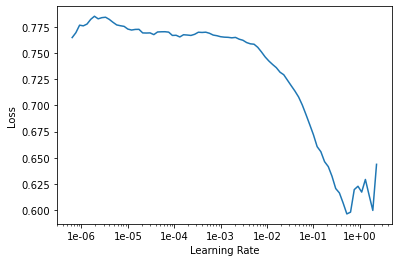

In [27]:
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.164466,0.490211,0.947738,24:10


In [78]:
learn.save(f'{m_path}/ms_pepOnly_first') 

In [37]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.099677,0.109846,0.964991,27:10


In [38]:
learn.save(f'{m_path}/ms_pepOnly_second') 

In [39]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.092842,0.099810,0.967430,30:59


In [40]:
learn.save(f'{m_path}/ms_pepOnly_third') 

In [41]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.103144,0.096412,0.969461,36:45
1,0.087395,0.092660,0.970501,35:58


In [42]:
learn.save(f'{m_path}/ms_pepOnly') 

# Test

In [48]:
data_test = (TextList.from_csv(f'{d_path}/test', 'test_pep.csv', vocab=data_lm.vocab, cols='peptide',
                              processor=[char_tokenize_processor, NumericalizeProcessor()])
             .split_none()
             .label_from_df(cols=3)
             .databunch(bs=bs))

data_test.save('data_test.pkl')

In [ ]:
data_test = load_data((f'{d_path}/test', 'data_test.pkl', bs=128)

In [30]:
df_test = pd.read_csv(f'{d_path}/test/test_pep.csv')

In [46]:
preds = []
for pep in df_test.peptide.values:
    preds.append(learn.predict(pep)[1].tolist())
df_test['preds'] = preds

In [45]:
preds = learn.get_preds(data_test)

KeyboardInterrupt: 

In [35]:
len(df_test[df_test.target==True])

16870

In [36]:
df_test[df_test.target==True].preds.sum()

382